In [1]:
import pandas as pd
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition

# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib

# Machine learning
import optuna # used for finding good hyperparameters for a model
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train = pd.read_csv("train.csv", index_col = "id")
test = pd.read_csv("test.csv", index_col = "id")

In [3]:
train.head()

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
id,,,,,,,,,,,,,,,,,,,,,
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,57.0,8.5,serosanguious,3.4,yes,2209,0,0,no,died
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,33.0,64.0,serosanguious,2.0,yes,2208,0,0,no,euthanized
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,37.0,6.4,serosanguious,3.4,yes,5124,0,0,no,lived
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,53.0,7.0,cloudy,3.9,yes,2208,0,0,yes,lived
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,47.0,7.3,cloudy,2.6,no,0,0,0,yes,lived


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1235 entries, 0 to 1234
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                1235 non-null   object 
 1   age                    1235 non-null   object 
 2   hospital_number        1235 non-null   int64  
 3   rectal_temp            1235 non-null   float64
 4   pulse                  1235 non-null   float64
 5   respiratory_rate       1235 non-null   float64
 6   temp_of_extremities    1196 non-null   object 
 7   peripheral_pulse       1175 non-null   object 
 8   mucous_membrane        1214 non-null   object 
 9   capillary_refill_time  1229 non-null   object 
 10  pain                   1191 non-null   object 
 11  peristalsis            1215 non-null   object 
 12  abdominal_distention   1212 non-null   object 
 13  nasogastric_tube       1155 non-null   object 
 14  nasogastric_reflux     1214 non-null   object 
 15  nasogastr

In [7]:
train.isna().sum().sort_values()

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
nasogastric_reflux_ph      0
outcome                    0
lesion_2                   0
lesion_3                   0
cp_data                    0
lesion_1                   0
abdomo_protein             0
surgical_lesion            0
packed_cell_volume         0
total_protein              0
capillary_refill_time      6
peristalsis               20
mucous_membrane           21
nasogastric_reflux        21
abdominal_distention      23
temp_of_extremities       39
pain                      44
abdomo_appearance         48
peripheral_pulse          60
nasogastric_tube          80
rectal_exam_feces        190
abdomen                  213
dtype: int64

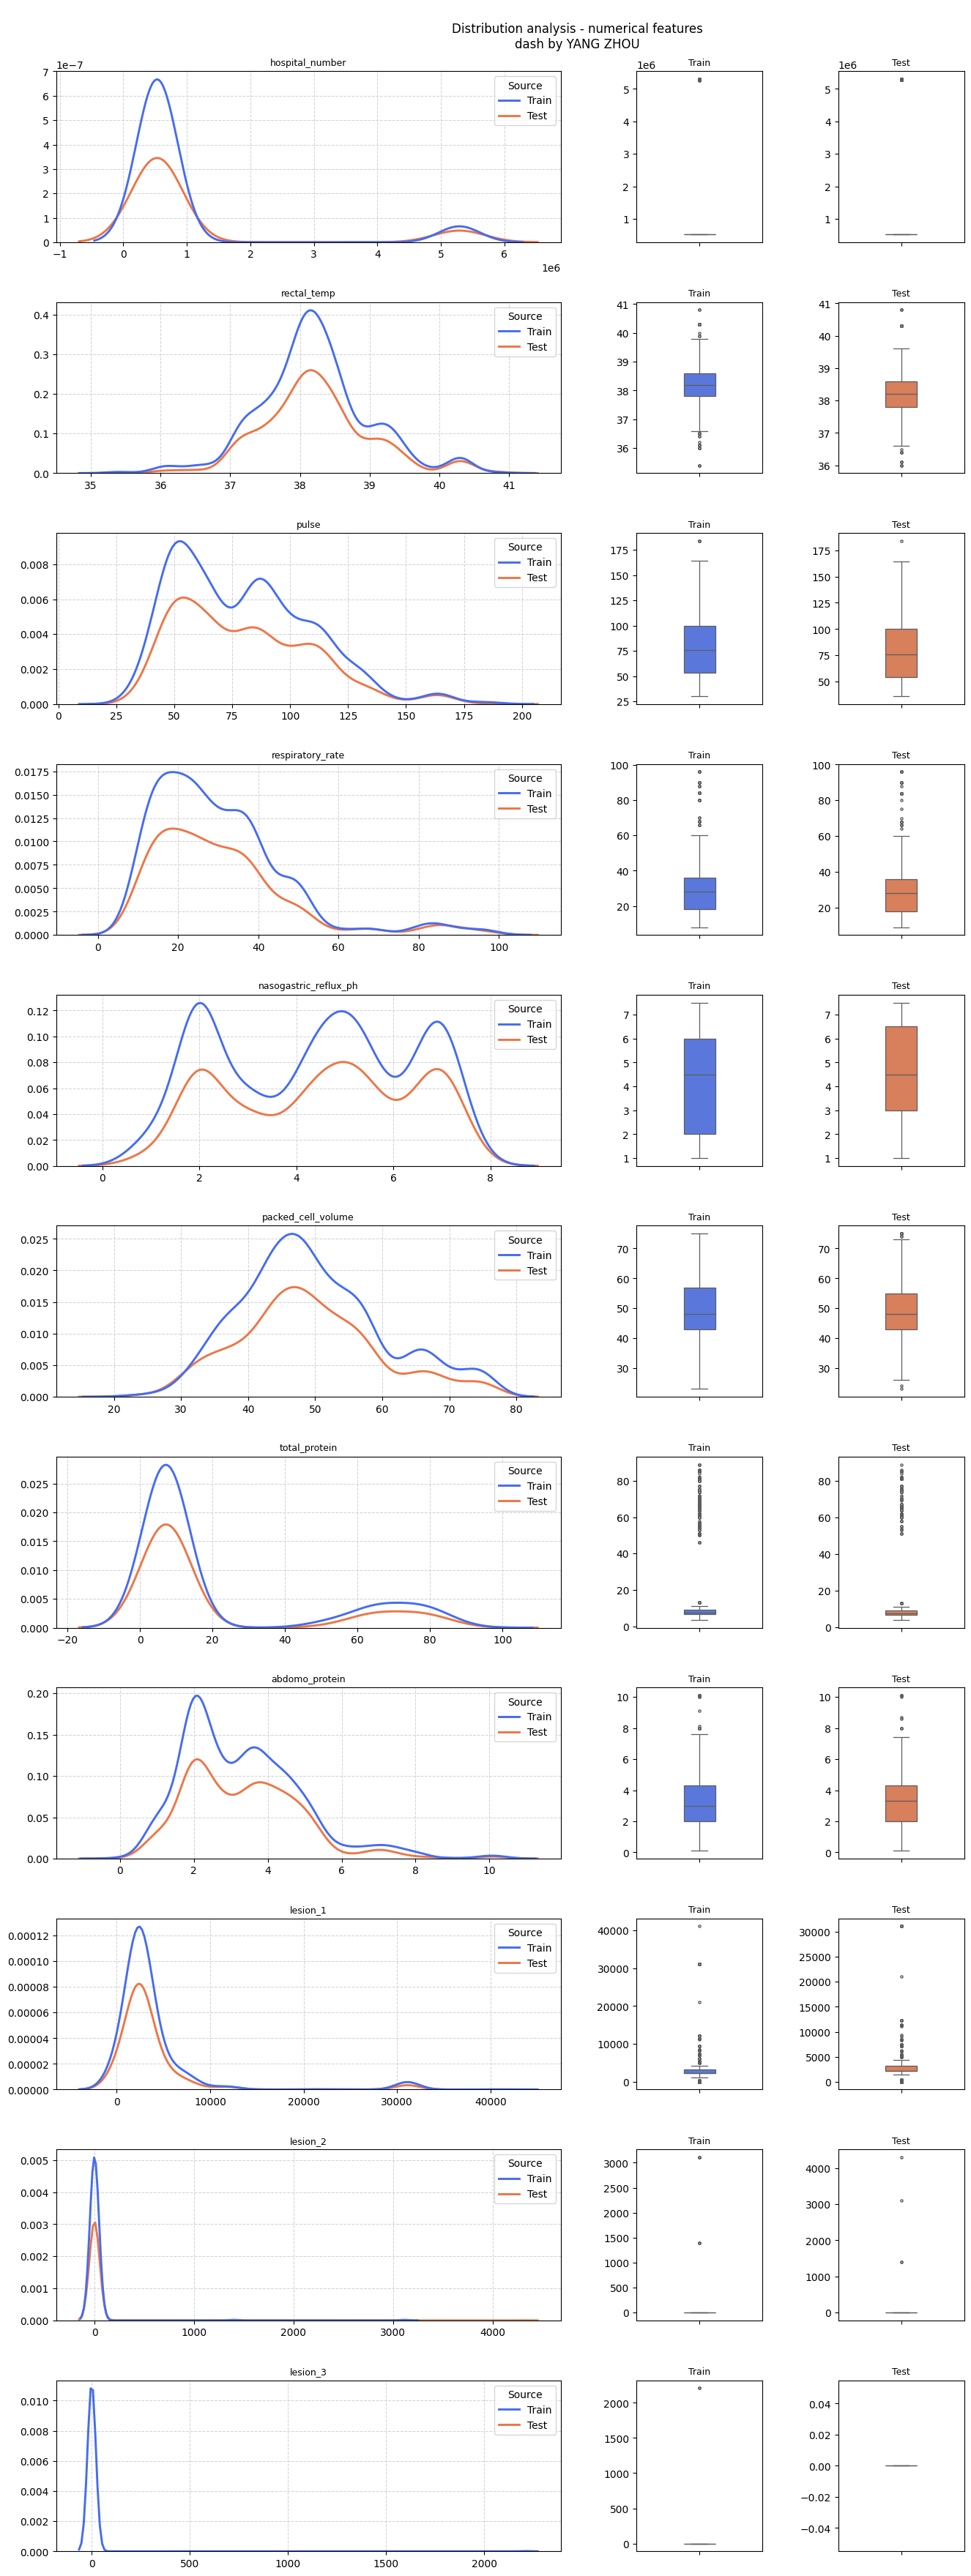

In [13]:
num = train.select_dtypes(include=['int64','float64']).columns

df = pd.concat([train[num].assign(Source = 'Train'), test[num].assign(Source = 'Test')], ignore_index = True)

# Use of more advanced artistic matplotlib interface (see the axes)
fig, axes = plt.subplots(len(num), 3 ,figsize = (16, len(num) * 4), gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20]})

for i,col in enumerate(num):
    ax = axes[i,0]
    sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', palette=['#456cf0', '#ed7647'], linewidth = 2.1, warn_singular=False, ax = ax) # Use of seaborn with artistic interface
    ax.set_title(f"\n{col}",fontsize = 9)
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75)
    ax.set(xlabel = '', ylabel = '')

    ax = axes[i,1]
    sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#456cf0', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Train", fontsize = 9)

    ax = axes[i,2]
    sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, linewidth = 0.90, fliersize= 2.25, color = '#ed7647', ax = ax)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title("Test", fontsize = 9)

plt.suptitle(f'\nDistribution analysis - numerical features\ndash by YANG ZHOU\n',fontsize = 12, y = 0.9, x = 0.57)
plt.show()

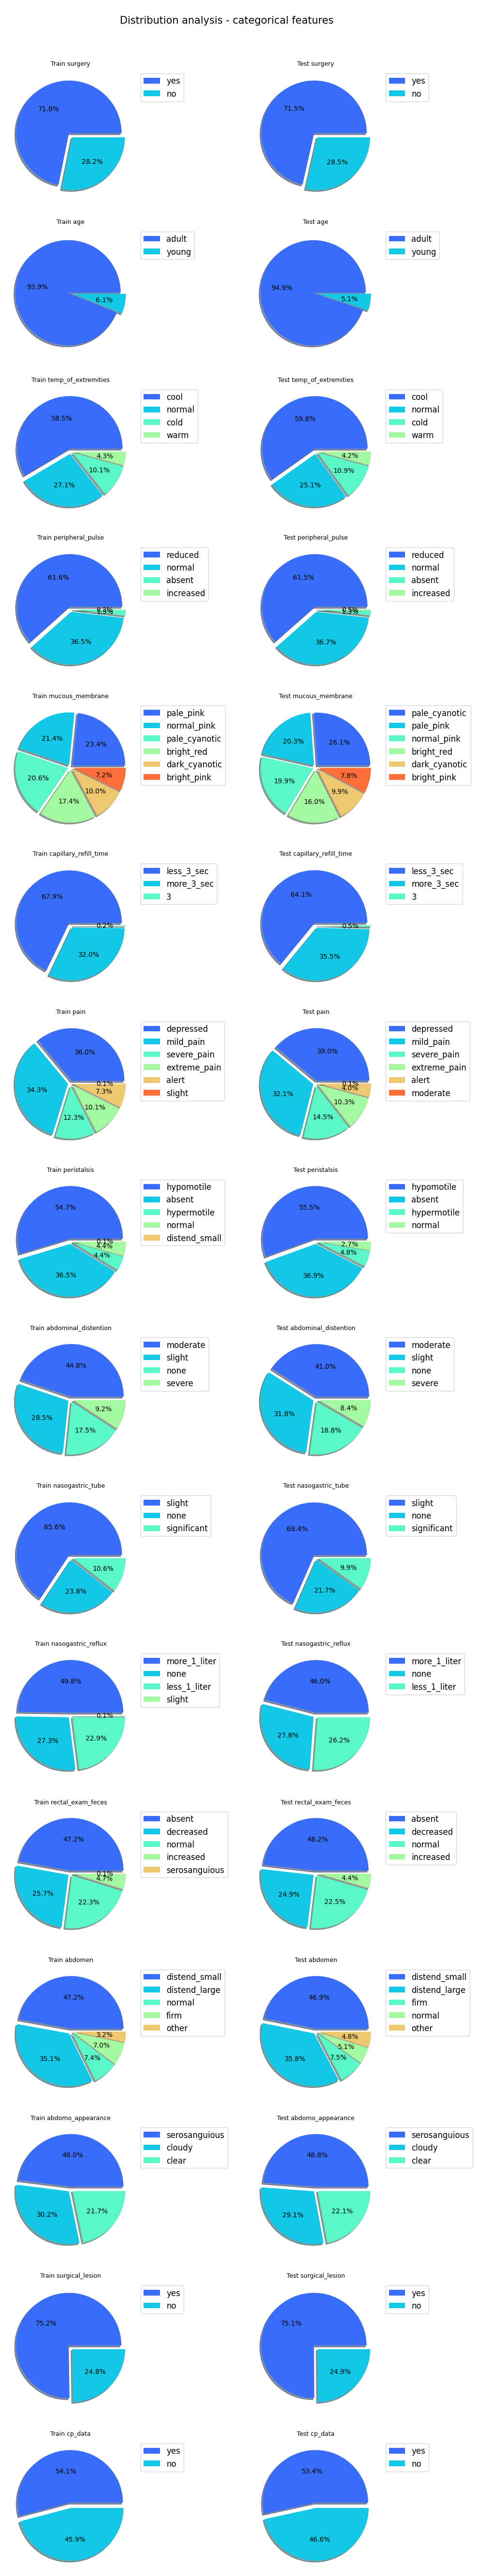

In [15]:
sns.set_palette('rainbow')

cat = train.drop(columns='outcome').select_dtypes(include=['object']).columns

df = pd.concat([train[cat].assign(Source = 'train'), 
                test[cat].assign(Source = 'test')], 
               axis=0, ignore_index = True)

fig, axes = plt.subplots(len(cat), 2 ,figsize = (12, len(cat) * 4.2))

for i,col in enumerate(cat):
    train_dist = df.loc[df.Source == 'train', [col]].value_counts()
    test_dist = df.loc[df.Source == 'test', [col]].value_counts()
    
    ax = axes[i,0]
    ax.pie(train_dist, shadow=True, explode=[.05]*len(train_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in train_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Train {col}',fontsize = 9)

    ax = axes[i,1]
    ax.pie(test_dist, shadow=True, explode=[.05]*len(test_dist), autopct='%.1f%%')
    ax.legend([category[0] for category in test_dist.index], loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    ax.set(xlabel = '', ylabel = '')
    ax.set_title(f'Test {col}',fontsize = 9)


plt.suptitle(f"\nDistribution analysis - categorical features\n",fontsize = 15, y = 0.9, x = 0.57)
plt.show()

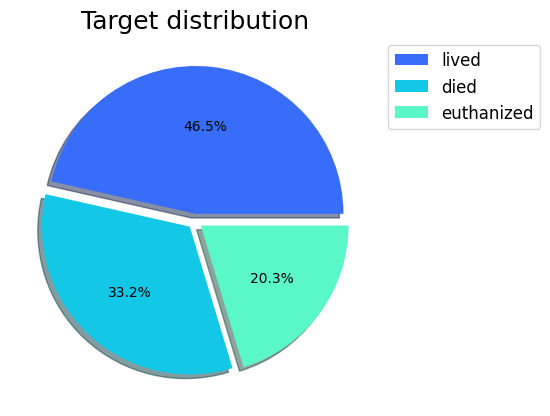

<Figure size 500x1000 with 0 Axes>

In [16]:
target_dist = train['outcome'].value_counts()

plt.pie(target_dist, shadow=True, explode=[.05,.05, .05], autopct='%.1f%%')

plt.title('Target distribution', size=18)
plt.legend(target_dist.index, loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

plt.figure(figsize=(5,10))

plt.show()

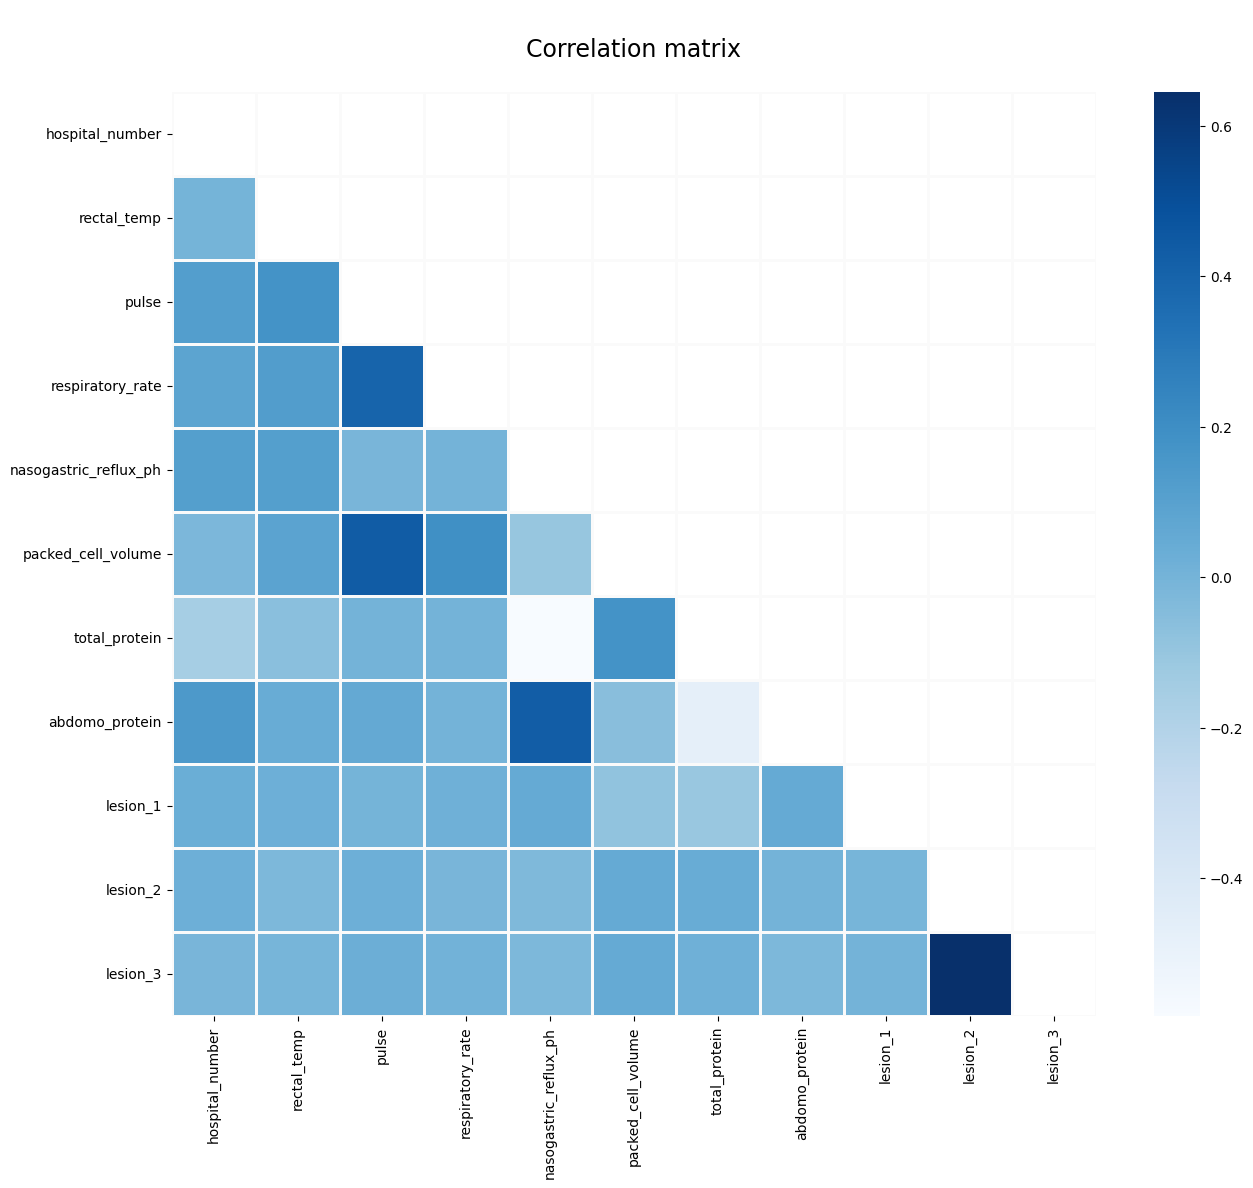

In [17]:
corr_matrix = train.select_dtypes(include=np.number).corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,12))
sns.heatmap(data=corr_matrix, mask=mask, cmap='Blues', linewidths=1, square=True, linecolor='#fafafa')
plt.title('\nCorrelation matrix\n', fontsize=17)
plt.show()



In [27]:
categorical_cols = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain','peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen','abdomo_appearance','lesion_2','surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']
threshold = .05

print(f'{"Column":<25} | Test result')
print('----------------------------------------')

for column in categorical_cols:
    # Create a contingency table
    contingency_table = pd.crosstab(train[column], train['outcome'])
    
    # Perform the Chi-Square test
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    print(f'{column:<25} |   ', '\033[32mPassed' if p < threshold else '\033[31mFailed', '\033[0m')

Column                    | Test result
--------------------------------------------------
temp_of_extremities       |    Passed 
peripheral_pulse          |    Passed 
mucous_membrane           |    Passed 
capillary_refill_time     |    Passed 
pain                      |    Passed 
peristalsis               |    Passed 
abdominal_distention      |    Passed 
nasogastric_tube          |    Passed 
nasogastric_reflux        |    Passed 
rectal_exam_feces         |    Passed 
abdomen                   |    Passed 
abdomo_appearance         |    Passed 
lesion_2                  |    Passed 
surgery                   |    Passed 
age                       |    Passed 
surgical_lesion           |    Passed 
lesion_3                  |    Failed 
cp_data                   |    Passed 


In [32]:
train.drop(columns='lesion_3', inplace=True) # Does the same

In [33]:
X_train = train.drop(columns='outcome')
y_train = train[['outcome']]

In [34]:
numerical_pipeline = make_pipeline(
#     SimpleImputer(strategy='mean'), # Tree based models like the LGBM deal with missing values better than SimpleImputer
    QuantileTransformer(output_distribution='normal', random_state=42),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
#     SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value' ,unknown_value=10)
)

In [35]:
transformer = make_column_transformer(
    (
        numerical_pipeline,
        make_column_selector(dtype_include=np.number) # We want to apply numerical_pipeline only on numerical columns
    ),
    (
        categorical_pipeline,
        make_column_selector(dtype_include=object) # We want to apply categorical_pipeline only on object (string) columns
    ),
    remainder='passthrough', # If any column where missed then don't drop them - we take care of every column so this line is not necessery
    verbose_feature_names_out=False # if False transformer won't add prefixes (name of the transformer that generated specific feature) to column names, column names are shorter that way
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('quantiletransformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=42)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1336e0550>),
                                ('pipeline-2',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=10))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x1336e1bd0>)],
                  verbose_feature_names_out=False)

In [36]:
target_encoder = OrdinalEncoder(categories=[['died', 'euthanized', 'lived']])

In [37]:
X_train = transformer.fit_transform(X_train)
y_train = target_encoder.fit_transform(y_train).ravel()

# If we saved y_train as pd.Series we would have to use this:
# y_train = target_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# There is even simpler approach without OrdinalEncoder
# y_train = y_train.map({'died':0,'euthanized':1,'lived':2})


In [38]:
X_train = pd.DataFrame(data=X_train, columns=transformer.get_feature_names_out(), index=train.index)
X_train.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
id,,,,,,,,,,,,,,,,,,,,,
0,0.105878,-0.109224,1.700853,-0.187200,0.602077,0.558758,0.532677,0.118752,0.204884,-0.080093,...,1.0,0.0,3.0,2.0,0.0,1.0,1.0,2.0,1.0,0.0
1,0.492654,-0.950993,0.350477,-1.401771,-0.658106,-1.490259,0.920788,-0.774723,0.048081,-0.080093,...,3.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,1.0,0.0
2,0.040881,0.252304,1.294186,0.031250,-0.196908,-1.022449,-0.940529,0.118752,0.785507,-0.080093,...,2.0,3.0,0.0,2.0,2.0,NaN,0.0,2.0,1.0,0.0
3,1.318004,-1.563261,-0.081099,0.163864,-0.658106,0.292826,-0.400509,0.463496,0.048081,-0.080093,...,3.0,3.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
4,2.417133,-0.336523,-0.782074,1.073563,0.936927,-0.189014,-0.175523,-0.231932,-3.004247,-0.080093,...,0.0,3.0,1.0,2.0,0.0,3.0,3.0,1.0,0.0,1.0


In [39]:
X_train.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,...,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,abdomo_appearance,surgical_lesion,cp_data
count,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,1.235000e+03,...,1191.000000,1215.000000,1212.000000,1155.000000,1214.000000,1045.000000,1022.000000,1187.000000,1235.000000,1235.000000
mean,-1.726015e-17,2.013684e-17,-2.589022e-17,-8.630074e-18,-8.630074e-18,4.315037e-18,1.654097e-17,2.157518e-18,-5.753382e-18,4.458871e-16,...,2.083963,1.902058,1.214521,1.418182,1.045305,1.023923,0.964775,1.262848,0.752227,0.540891
std,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,1.000405e+00,...,1.219451,1.475038,1.279394,0.848599,0.709439,1.191606,1.004755,0.793094,0.431894,0.498527
min,-5.050505e+00,-5.051426e+00,-5.020929e+00,-4.840693e+00,-3.596834e+00,-4.150241e+00,-5.034929e+00,-5.083975e+00,-3.004247e+00,-8.009297e-02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.546484e-01,-6.050247e-01,-6.981833e-01,-6.315291e-01,-6.581064e-01,-5.607593e-01,-6.421395e-01,-7.747232e-01,-2.051666e-01,-8.009297e-02,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,3.254254e-03,7.159243e-02,-9.607834e-03,3.124956e-02,2.686444e-02,-6.902327e-02,1.362882e-02,-3.330905e-02,2.048838e-01,-8.009297e-02,...,2.000000,3.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,6.550365e-01,7.175869e-01,6.836918e-01,4.815389e-01,5.060942e-01,5.587579e-01,6.469165e-01,6.512488e-01,5.254878e-01,-8.009297e-02,...,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000
max,5.057013e+00,5.057896e+00,5.011396e+00,4.800778e+00,3.691014e+00,4.029959e+00,5.030611e+00,5.051598e+00,3.311785e+00,1.500267e+01,...,5.000000,4.000000,3.000000,2.000000,3.000000,4.000000,4.000000,2.000000,1.000000,1.000000


In [41]:
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, train_size=0.8)

In [42]:
def objective(trial):
#     model = LGBMClassifier(
#         n_estimators = trial.suggest_int('n_estimators', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5),
#         max_depth = trial.suggest_int('max_depth', 1, 10),
#         num_leaves = trial.suggest_int('num_leaves', 2, 1024),
#         reg_lambda  = trial.suggest_float('reg_lambda', 0.001, 10),
#         reg_alpha = trial.suggest_float('reg_alpha', 0, 10),
#         subsample = trial.suggest_float('subsample', 0.001, 1),
#         colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
#         min_child_samples = trial.suggest_int('min_child_samples', 2, 1024),
#         min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
#         objective = trial.suggest_categorical('objective', ['multiclass']),
#         metric = trial.suggest_categorical('metric', ['multi_logloss']),
#         boosting_type = trial.suggest_categorical('boosting_type', ['gbdt']),
#     )
    
#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10),
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 10),
#         grow_policy = trial.suggest_categorical('grow_policy', ['Depthwise']),
#         bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian']),
#         od_type = trial.suggest_categorical('od_type', ['Iter']),
#         eval_metric = trial.suggest_categorical('eval_metric', ['TotalF1']),
#         loss_function = trial.suggest_categorical('loss_function', ['MultiClass']),
#         random_state = trial.suggest_categorical('random_state', [42]),
#         verbose = trial.suggest_categorical('verbose', [0])
#     )

    model = XGBClassifier(
        eta = trial.suggest_float('eta', 0.001, 0.3),
        n_estimators = trial.suggest_int('n_estimators', 32, 1024),
        max_depth = trial.suggest_int('max_depth', 1, 10),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1),
        objective = trial.suggest_categorical('objective', ['multi:softmax'])
    )
    
    model.fit(
        X_train_optuna, y_train_optuna,
        eval_set=[(X_train_optuna, y_train_optuna), (X_val_optuna, y_val_optuna)],
        verbose=False
    )
    
    return f1_score(y_val_optuna, model.predict(X_val_optuna), average='micro') # micro F1 is used in this competitons for evaluation so we will use it for hyperparameter optimization

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params

[I 2023-09-30 11:19:35,013] A new study created in memory with name: no-name-1152c433-ad07-49f6-aa75-dccdb7642f90
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/valeredem

In [44]:
model = XGBClassifier(best_hyperparams)
cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_micro').sum() / 5
print(f'{model.__class__.__name__} micro F1 cross-validation score: {cv_score:.3f}')

/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(

XGBClassifier micro F1 cross-validation score: 0.704


/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

In [45]:
model.fit(X_train, y_train)

/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [46]:
train_score = f1_score(y_train, model.predict(X_train), average='micro')
print(f'{model.__class__.__name__} micro F1 training score: {train_score:.3f}')

XGBClassifier micro F1 training score: 1.000


/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

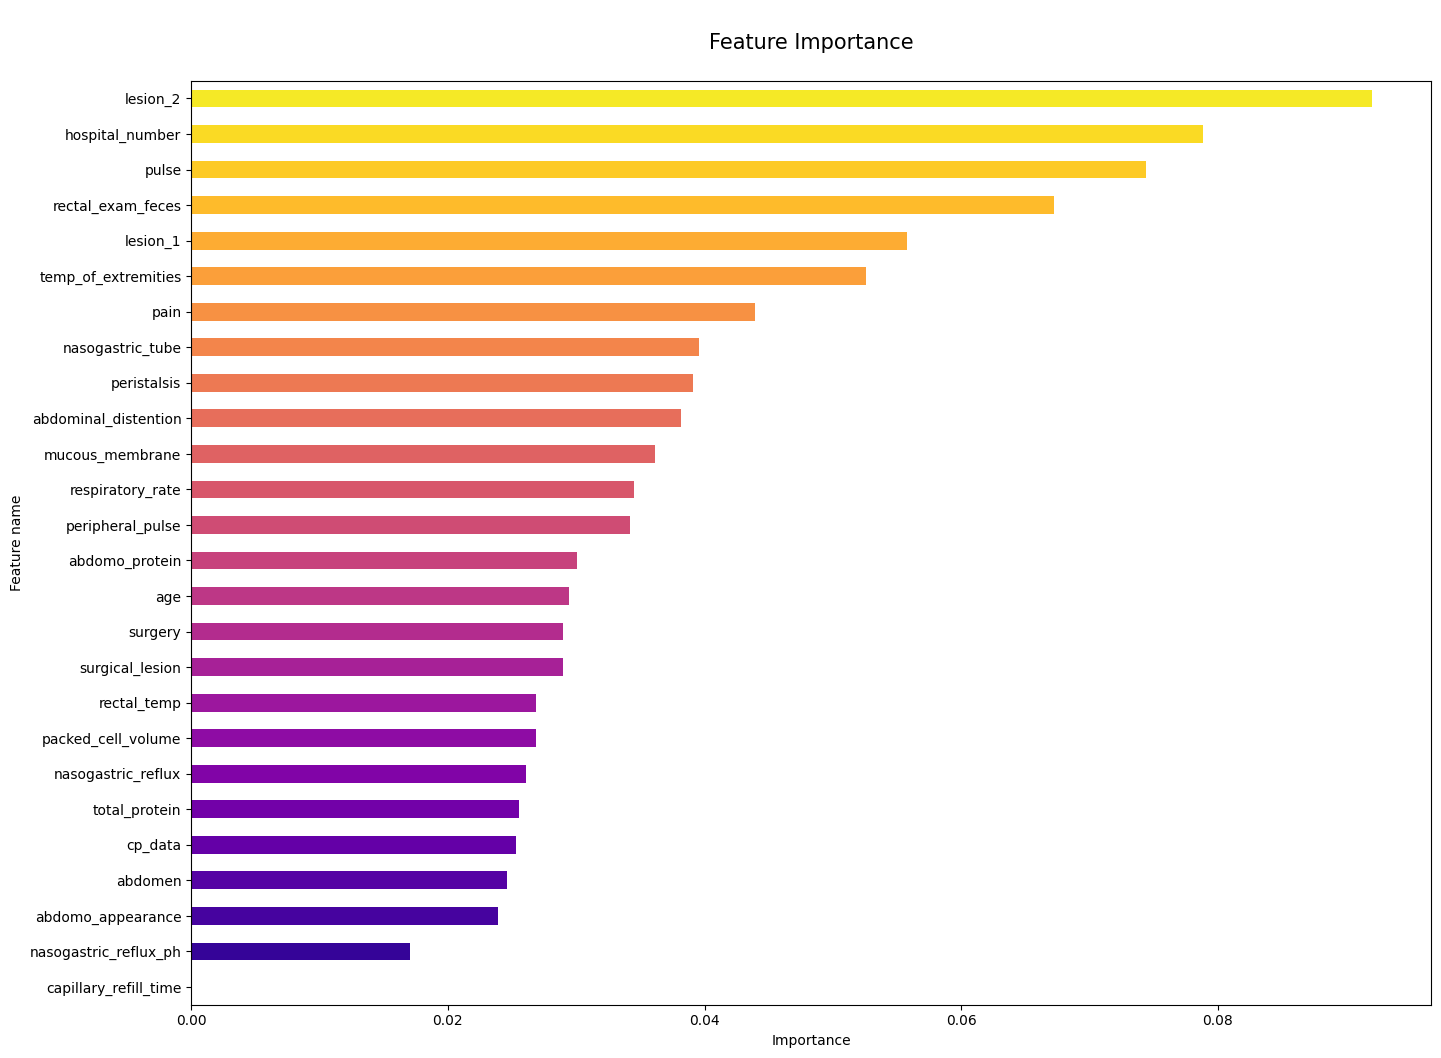

In [47]:
feature_importance = pd.DataFrame(data = {'feature': train.columns[:-1], 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=True)

feature_importance.plot(kind='barh', x='feature', y='importance', legend=False, color=sns.color_palette('plasma', n_colors=len(feature_importance)), figsize=(16, 12))

plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.title('\nFeature Importance\n', fontsize=15)
plt.show()


In [48]:
test.drop('lesion_3', axis=1, inplace=True)

X_test = pd.DataFrame(data=transformer.transform(test), columns=transformer.get_feature_names_out(), index=test.index)

In [49]:
predictions = []
predictions.append(model.predict(X_test).ravel()) # CatBoostClassifier's predictions are of shape (n ,1) and not (n, ) like other models so we have to use .ravel()

# Mode doesn't work on python lists only on ndarray (numpy arrays)
predictions = np.array(predictions)

# Take the most frequent prediction out of 3 models
final_predictions, _ = stats.mode(predictions, axis=0)

final_predictions.shape

/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/valeredemelier/Documents/GitHub/Kaggle-Fall-2023/.venv/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_

(824,)

In [51]:
submission = pd.read_csv('sample_submission.csv', index_col='id')
submission['outcome'] = target_encoder.inverse_transform(final_predictions.reshape(-1, 1)).ravel()
submission.to_csv('submission2.csv')